# PART 1 : SEGMENTATION + NOISE ADD

In [4]:
import os
import sys
import copy
from matplotlib import pyplot as plt

%matplotlib inline

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import data_augmentation
from NN_segmentation.tst_dataset import cardiacdata
import numpy as np

In [5]:
# LOAD DATA
path_data = r"/home/jovyan/project_data/ACDC-Daten"
add_noise = True
single_noise_probability = 50

data_list = []
label_list = []

for root, _, files in os.walk(path_data):
    if os.path.isfile(os.path.join(root, "image.nii.gz")):
        try:
            data_list.append(cardiacdata(img_dir=os.path.join(root, "image.nii.gz"), label_dir=os.path.join(root, "label.nii.gz")))
        except:
            pass
        
data_noise = []#copy.deepcopy(data_list)
for i in range(len(data_list)):
    noisy_data = []
    for j in range(data_list[i].img.shape[0]):
        for k in range(data_list[i].img.shape[1]):
            noisy_data.append(data_augmentation.augmentation(np.squeeze(data_list[i].img[j,k,:,:]), single_noise_probability))
    data_noise.append(np.array(noisy_data).reshape(data_list[i].img.shape))
    
data_noisy_list = copy.deepcopy(data_list)
for i in range(len(data_list)):
    data_noisy_list[i].img = data_noise[i]

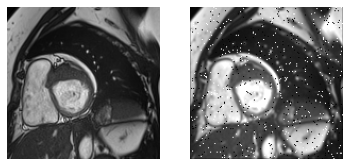

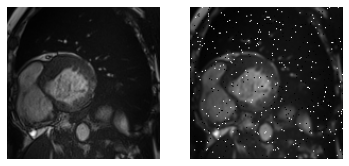

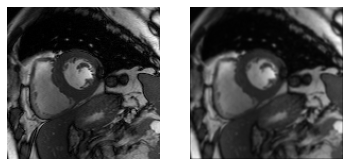

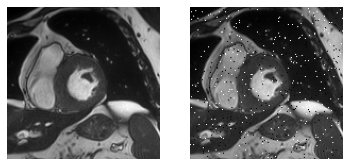

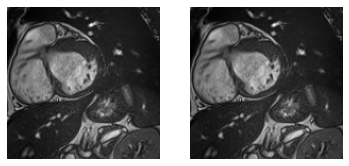

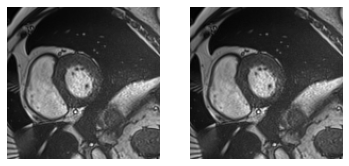

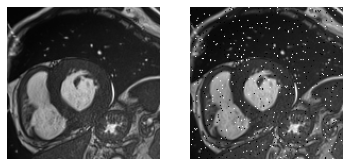

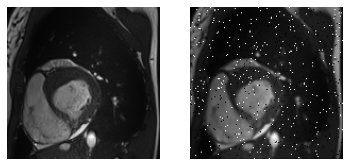

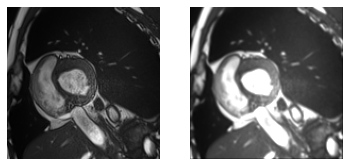

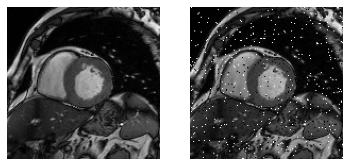

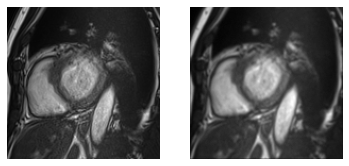

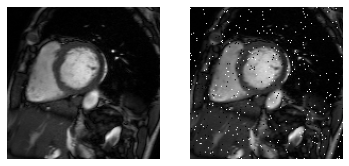

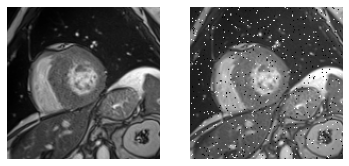

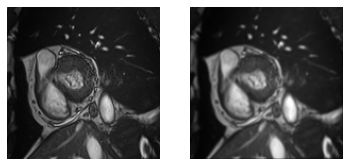

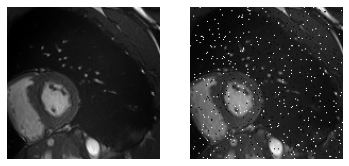

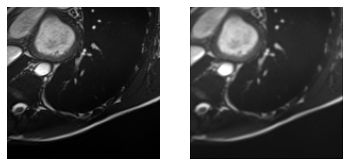

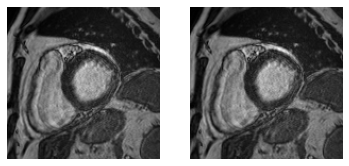

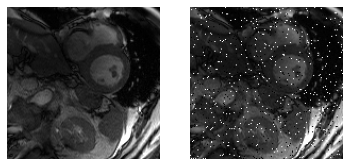

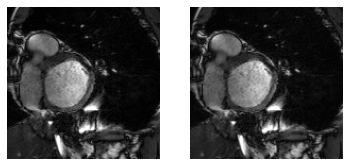

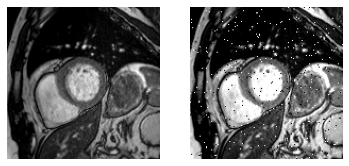

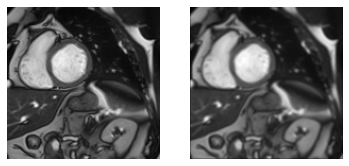

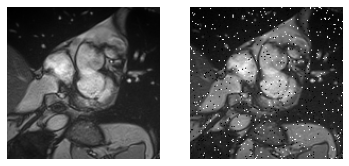

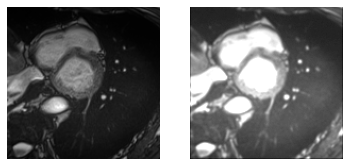

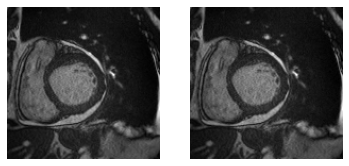

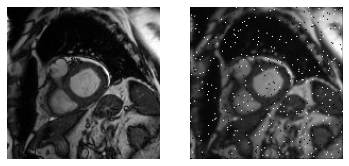

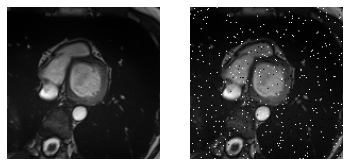

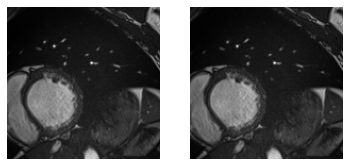

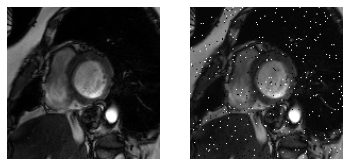

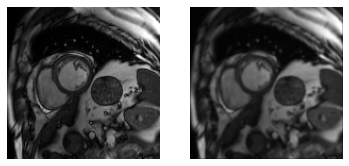

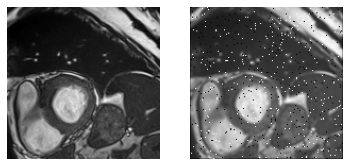

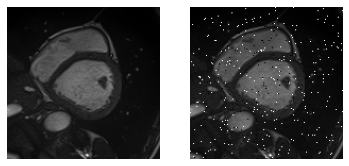

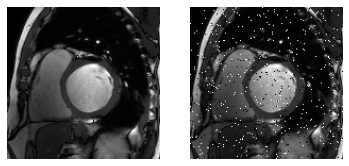

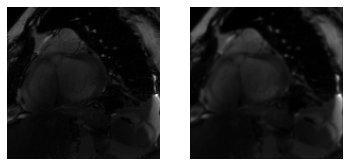

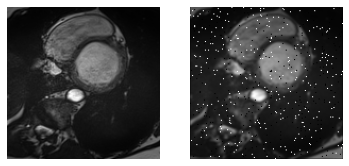

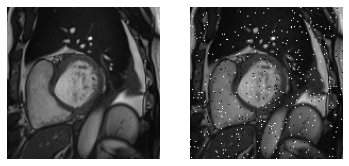

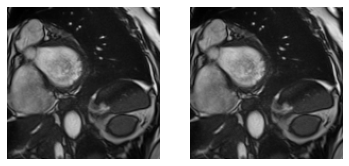

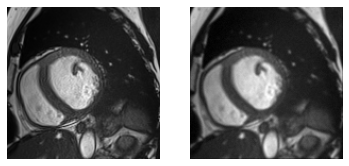

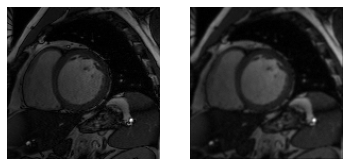

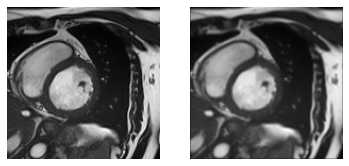

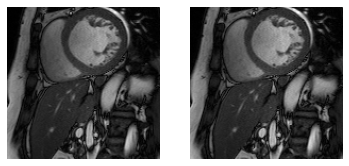

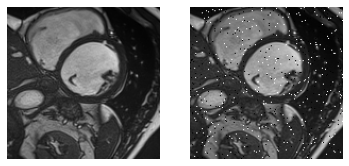

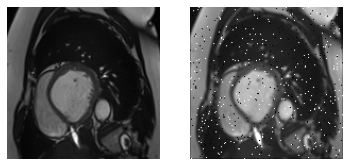

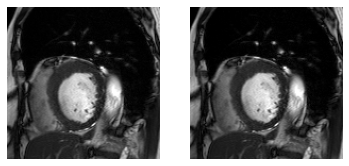

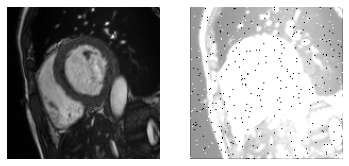

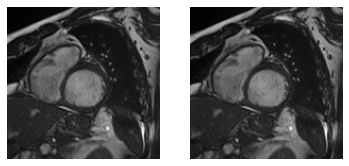

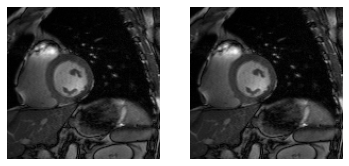

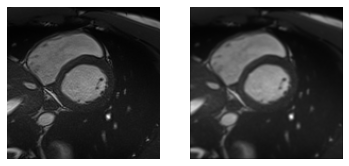

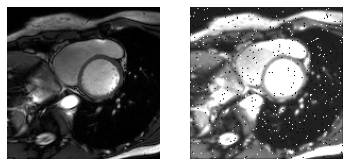

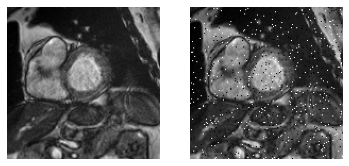

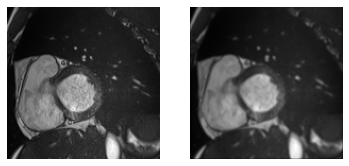

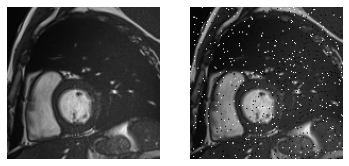

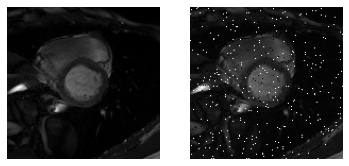

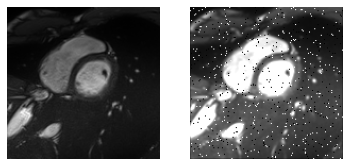

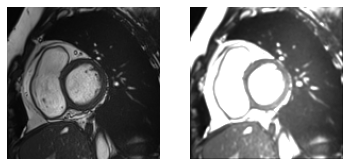

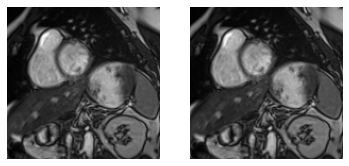

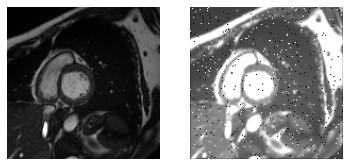

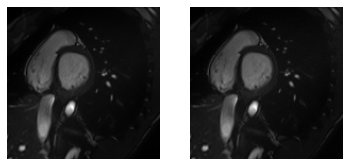

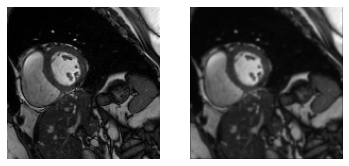

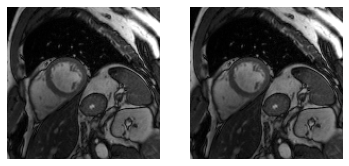

In [6]:
for num in range(len(data_list)):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(np.squeeze(data_list[num].img[0,0,:,:]), cmap="gray")
    axes[0].axis("off")
    axes[1].imshow(np.squeeze(data_noisy_list[num].img[0,0,:,:]), cmap="gray")
    axes[1].axis("off")
    plt.show()